# Baseball Data Analysis

This project involves analyzing baseball data to determine relations between different performance metrics and variables. The analysis is performed on baseball data containing batting and pitching statistics from 1871 to 2016 along with other information such as player salaries, Hall of Fame voting data and All Star Game details.

Based on the data, the following questions are investigated:

**Question 1**: In sports is often said, "A team is as good as its best player". Is this true?

**Question 2**: What are the performance criteria required for gaining an entry into the Hall of Fame as a player?

**Question 3**: How much are All Star players paid compared to the rest of the field? Is this justified?

For the Analyis, the following tables are used:
1. AllStarFull.csv
2. Batting.csv
3. HallOfFame.csv
4. Pitching.csv
5. Salaries.csv
6. Master.csv
7. Teams.csv

Information for each table and data used for the analysis can be found [here](http://www.seanlahman.com/baseball-archive/statistics/).

First all the packages and files required for the analysis are loaded into python.

To make merging easier, we will be renaming some columns in the "Teams.csv" file, after uploading it to the dataframe "team_details". The following columns will be renamed:
1. "R" to "R_team"
2. "W" to "W_team"
3. "ERA" to "ERA_team"
4. "G" to "G_team"
5. "SO" to "SO_batters"

Also, multiple files will be merged through the course of the analysis to make data visualization easier. The combinations will take place on filtered data and not on the master tables being imported.

In [1]:
#importing all the necessary packages and functions which will be required
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#importing the data required for analysis and storing it in pandas DataFrames

all_star_details = pd.read_csv('AllStarFull.csv')

batting_regular_season = pd.read_csv('Batting.csv')

HOF_details = pd.read_csv('HallOfFame.csv')

pitching_regular_season = pd.read_csv('Pitching.csv')

salary_details = pd.read_csv('Salaries.csv')

player_details = pd.read_csv('Master.csv')

team_details = pd.read_csv('Teams.csv')

team_details.rename(columns={'G':'G_team','W':'W_team','ERA':'ERA_team','SO':'SO_batters','R':'R_team'}, inplace=True)

Now that all data has been loaded, we begin by looking at the first question.

**Question 1**: In sports is often said, "A team is as good as its best player". Is this true?

To answer this question, we will find the top regular season batters and pitchers for each team, each year and compare their performance with the performance of their respective team to see if a relation exists. The top performing batters each year are determined by comparing their RBIs (Runs Batted In) to rest of their team and the top performing pitchers are identified by comparing their ERA (Earned Run Average) to the rest of their team. RBI and ERA are selected for this analysis as they are widely accepted as the metric used for quantifying individual performance in baseball. The correlation between top player performance and team performance through the years can be achieved through the calculation of the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between RBIs and win percentage for the batters & ERA and win percentage for the pitchers.

Thus, tables being analyzed to answer this question:
1. "Teams.csv"
2. "Batting.csv"
3. "Pitching.csv"

Components being analyzed in Batting.csv and Pitching.csv - RBI and ERA.

Components being analyzed in Teams.csv - W_team and G_team.

Our analysis for this question is being performed based on certain assumptions:
1. Individuals who played atleast 20 games per year are only considered.
2. Analysis is performed for year 1962 onwards when majority of the teams played a standard 162 games (apart from the 1995 season).
3. This question is being answered for regular season performance only by analyzing the best players for each team that year, post season performance is not being considered.

> Note: Higher RBIs means a better performance for batters, lowers ERA means better performance for the pitchers

Thus, we start by identifying the top batters and pitchers for each team every year, combining the team performance for that year, calculating the win percentage and then determining the pearson correlation coefficient.

In [3]:
def best_player_on_team(data,role,field):
    '''Function to identify the top performers in the league since 1962 who have atleast player 20 games in a season. Accepts 
    the data that needs to be gone through, role(min/max for the particular field) and the field that needs to be looked at to 
    identify the top performers each year.'''
    
    more_than20_games_all_years = data[data["G"]>=20]
    more_than20_games_since_1962= more_than20_games_all_years[more_than20_games_all_years["yearID"]>=1962]   
    if (role=="max"):
        best_players = more_than20_games_since_1962.loc[more_than20_games_since_1962.groupby(['yearID','teamID'])[field].idxmax()]
    elif (role=="min"):
        best_players = more_than20_games_since_1962.loc[more_than20_games_since_1962.groupby(['yearID','teamID'])[field].idxmin()]
    
    combined_data = best_players.merge(team_details,on=["yearID","teamID"],how='inner')
    return combined_data    

#higher RBI - better performance for batter, lower ERA - better performance for pitcher
best_batter_per_team = best_player_on_team(batting_regular_season,'max','RBI')
best_pitcher_per_team = best_player_on_team(pitching_regular_season,'min','ERA')

def winning_percent(wins,total_games):
    '''Function to determine the winning percentage.'''
    return (wins/total_games)

#determine the team win percentage for each top performer
winning_percent_bat_team = winning_percent(best_batter_per_team['W_team'],best_batter_per_team['G_team'])
winning_percent_pitch_team = winning_percent(best_pitcher_per_team['W_team'],best_pitcher_per_team['G_team'])

In [4]:
#function to standardize the values
def standardize(values):
    return ((values-values.mean())/values.std(ddof=0))

#function to determine the Pearson Correlation Coefficient
def coeff(val1, val2):
    standardized_val1 = standardize(val1)
    standardized_val2 = standardize(val2)
    return standardized_val1*standardized_val2

coeff_bat_win = coeff(best_batter_per_team['RBI'],winning_percent_bat_team)
coeff_pitch_win = coeff(best_pitcher_per_team['ERA'],winning_percent_pitch_team)

print("Pearsons Coefficient for Top RBIs and Winning Percentage = " + str(coeff_bat_win.mean()))
print("Pearsons Coefficient for Top ERA and Winning Percentage = " + str(coeff_pitch_win.mean()))

Pearsons Coefficient for Top RBIs and Winning Percentage = 0.38568517966206556
Pearsons Coefficient for Top ERA and Winning Percentage = -0.3254129413692042


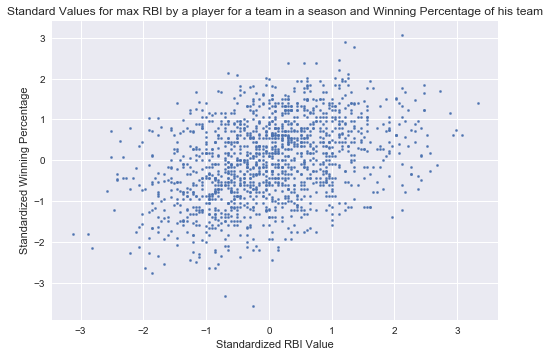

In [5]:
def scatter_plot(xData, yData, title, xAxis, yAxis, size=5):
    '''Function for creating a scatter plot, accepts the data to be plotted (xData & yData), the Axis labels (xAxis, yAxis), the
    title (Title) and the size of the data to be plotted(size).'''
    plt.scatter(xData, yData, s=size)
    plt.xlabel(xAxis)
    plt.ylabel(yAxis)
    plt.title(title)
    
#Creating a scatter plot for the standard values of RBIs and Winning Percentage to visualize the correlation
scatter_plot(standardize(best_batter_per_team['RBI']),standardize(winning_percent_bat_team),
            'Standard Values for max RBI by a player for a team in a season and Winning Percentage of his team',
            'Standardized RBI Value','Standardized Winning Percentage')

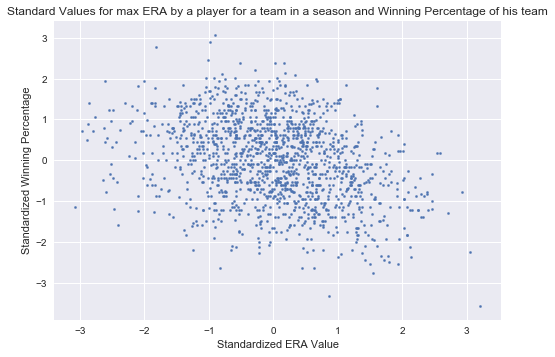

In [6]:
#Similarly, creating a scatter plot for the standard values of ERA and Winning Percentage to visualize the correlation

scatter_plot(standardize(best_pitcher_per_team['ERA']),standardize(winning_percent_pitch_team),
            'Standard Values for max ERA by a player for a team in a season and Winning Percentage of his team',
            'Standardized ERA Value','Standardized Winning Percentage')

According to the analysis performed above, we see that the pearson coefficient between RBI posted by the top batsman and win percentage posted by his team is positive and thus the two variables are correlated which is expected as more runs scored will give a team better chance of winning. Although, the pearson coefficient isn't very high, there seems to be a dependence between the two variables. The same can be seen through the first scatter plot.

On the other hand, the pearson coefficient between the ERA posted by the top pitcher and the win percentage posted by his team shows a negative relation which is also expected as a lower ERA posted by the best pitcher on a team will give his team a better chance of winning. Thus, looking at the scatter plot and the Pearson correlation coefficient we can say that a relation between the ERA posted by the best pitcher on a team and the win percentage posted by his team exists, even though it may not be very strong.

To confirm the distribution we achieved above, analysis is also been performed using Runs instead of RBIs with the winning percentage for determining the Pearson coefficient for batters and using Strike outs instead of ERA with winning percentage for determining the Pearson coefficient for pitchers.

In [7]:
#performing the same analysis but using Runs instead of RBI for batters and Strike outs instead of ERA for pitchers in the 
#analysis
#higher Runs - better performance for batter, higher Strike Outs - better performance for pitcher
best_batter_per_team_r = best_player_on_team(batting_regular_season,'max','R')
best_pitcher_per_team_so = best_player_on_team(pitching_regular_season,'max','SO')

#determine the team win percentage for each top performer
winning_percent_bat_team_r = winning_percent(best_batter_per_team_r['W_team'],best_batter_per_team_r['G_team'])
winning_percent_pitch_team_so = winning_percent(best_pitcher_per_team_so['W_team'],best_pitcher_per_team_so['G_team'])

#determine the Pearson Coefficient using functions described above
coeff_bat_win_r = coeff(best_batter_per_team_r['R'],winning_percent_bat_team_r)
coeff_pitch_win_so = coeff(best_pitcher_per_team_so['SO'],winning_percent_pitch_team_so)

print("Pearsons Coefficient for Top Runs scored and Winning Percentage = " + str(coeff_bat_win_r.mean()))
print("Pearsons Coefficient for Top Strike Outs pitched and Winning Percentage = " + str(coeff_pitch_win_so.mean()))

Pearsons Coefficient for Top Runs scored and Winning Percentage = 0.4378974901073114
Pearsons Coefficient for Top Strike Outs pitched and Winning Percentage = 0.26822583360909724


From, the above value of the Pearson Coefficient, we see that there is a stronger relation between the maximum runs scored by a player on a team and the winning percentage posted by his team than was the case for RBIs posted and the win percentage achieved by the team. However, RBIs are considered a [truer measurement of individual batting performance than runs scored](http://www.seanlahman.com/baseball-archive/sabermetrics/sabermetric-manifesto/). This makes the statement we are investigating untrue.

On the other hand, the value of Pearson Coefficient for maximum Strike Outs pitched and Winning Percentage posted by the respective team shows a lesser correlation than what was achieved for ERA and winning percentage (It is better to have lower ERA and higher Strike Outs). And as, ERA is [truer measurement of individual pitching performance than strike outs pitched than any other metric](http://www.seanlahman.com/baseball-archive/sabermetrics/sabermetric-manifesto/) we have, it makes the statement we are investigating true.

As both statements discussed in the paragraphs above are contradictory in nature, it is difficult to definitively conclude whether better individual performance leads to better team results. Thus, based on the assumptions taken and the analysis performed, I would say that even though there is a correlation between a teams performance and the performance of its best player, it is not strong enough as shown by the value of the Pearson coefficient for me to agree with the statement, "A Team is as good as its best player".

Now, moving on to Question 2,

**Question 2**: What are the performance criteria required for gaining an entry into the Hall of Fame (HOF) as a player?

To answer this question, we will first identify the players, who have gained entry into the hall of fame and combine their stats over the course of their careers into one index. We will then calculate the average statistics for batters and pitchers seperately. These average statistics can represent a criteria required for an entry into the Hall of Fame. We will also identify individuals who meet this criteria and thus, can possibly be inducted into the Hall of Fame.

To answer this question, the following considerations are being made:
1. Players selected by the BBWAA (Baseball Writers Association of America) only and inducted as "players" in the HOF are selected for analysis.
2. Criteria used to identify batters not in HOF - runs scored, home runs, total hits, RBIs
3. Criteria used to identify pitchers not in HOF - pitchers Win, strike outs, shutouts, outs pitched 
4. All the players that meet the criteria in point 2 and 3 should have played atleast 250 games.

Thus, tables being analyzed to answer this question:
1. "HallofFame.csv"
2. "Batting.csv"
3. "Pitching.csv"
4. "Master.csv"

Components being analyzed in Batting.csv - RBI (RBI), Runs Scored (R), Hits (H) and Home Runs (HR).

Components being analyzed in Pitching.csv - Strike Outs (SO), Shout Outs(SH), Pitcher Wins(W) and Outs Pitched (IPouts).

Components being analyzed in HallOfFame.csv - Category, votedby and inducted.

Components being analyzed in Master.csv - First Name and Last Name.

In [8]:
#identifying individuals who have gained entry to hall of fame as players having been selected by the BBWAA
conditions = (HOF_details['category']=='Player')&(HOF_details['votedBy']=='BBWAA')&(HOF_details['inducted']=='Y')
hof_players_inducted = HOF_details[conditions]

#We will now calculate the overall stats of the players throughout their careers
batters = batting_regular_season.groupby('playerID',as_index=False).sum()
pitchers = pitching_regular_season.groupby('playerID',as_index=False).sum()

#We will drop the column "yearID","stint" from the batters and pitchers DataFrames as we don't require it
del batters['stint']
del batters['yearID']
del pitchers['stint']
del pitchers['yearID']

#Calculating the batters and pitchers in the HOF
batters_inducted_in = batters[batters['playerID'].isin(hof_players_inducted['playerID'])]
pitchers_inducted_in = pitchers[pitchers['playerID'].isin(hof_players_inducted['playerID'])]

print("Total batters selected = " + str(len(batters_inducted_in)))
print("Total pitchers selected = " + str(len(pitchers_inducted_in)))
print("Total players selected = " + str(len(hof_players_inducted)))

Total batters selected = 119
Total pitchers selected = 49
Total players selected = 119


From above we see that the total batters inducted into the hall of fame also includes batting data for certain the pitchers inducted into the hall of fame and vice-versa. As the statistics posted by the pitchers in the batting table are not representative of the reason why they were inducted into the Hall of Fame, these entries will be removed before proceding further, same will be done for batters in the pitching table.

To determine the batters in the pitching table that have to be removed, the criteria used will be pitching Wins > 10

To determine the pitchers in the batting table that have to be removed, the criteria used will be runs > 200

If there still remain some players that are present in both the tables, they will not be removed as it may be the case that they have been inducted into the HOF because of their overall excelence in both batting and pitching.

Once this 'cleaning' has been performed we will identify the players (both batters and pitchers) that meet the criteria of being in the HOF but are currently not in it. Finally, the average statistics of the HOF players and the names of the players who meet the criteria and not in the HOF will be printed. 

In [9]:
pitchers_inducted = pitchers_inducted_in[pitchers_inducted_in['W']>10]
batters_inducted = batters_inducted_in[batters_inducted_in['R']>200]

#calcualting the mean stats for HOF players
mean_HOF_batters = batters_inducted.mean()
mean_HOF_pitchers = pitchers_inducted.mean()

#comparing the criteria with other players to determine the players deserving to be in the HOF and aren't already in it

def conditions(masterFile, meanFile, field1, field2, field3, field4):
    '''Defining the criteria required for HOF entry. masterFile - File name where conditions need to be checked, meanFile - 
    File name which contains the values to be checked against, field# - Fields to be checked'''
    cond1 = (masterFile[field1]>meanFile[field1])&(masterFile[field2]>meanFile[field2])
    cond2 = (masterFile[field3]>meanFile[field3])&(masterFile[field4]>meanFile[field4])
    cond_games_greater_than250 = (masterFile['G']>250)
    return (cond1&cond2&cond_games_greater_than250)

batting_cond = conditions(batters, mean_HOF_batters,'R', 'H', 'RBI', 'HR')
pitching_cond = conditions(pitchers, mean_HOF_pitchers, 'W', 'SO', 'SHO', 'IPouts')

#putting in the conditions and removing the NaN values achieved for results not satisfying the condition
batters_meet_criteria_nan = batters.where(batting_cond)
batters_meet_criteria = batters_meet_criteria_nan.dropna(axis='index',how='all')

pitchers_meet_criteria_nan = pitchers.where(pitching_cond)
pitchers_meet_criteria = pitchers_meet_criteria_nan.dropna(axis='index',how='all')

#finding batters that meet the criteria are not in the HOF
batters_meet_criteria_notHOF = batters_meet_criteria[~(batters_meet_criteria['playerID'].isin(batters_inducted['playerID']))]
pitchers_meet_criteria_notHOF = pitchers_meet_criteria[~(pitchers_meet_criteria['playerID'].isin(pitchers_inducted['playerID']))]

#identifying player names based on 'playerID'
player_details_HOF = player_details[(player_details['playerID'].isin(batters_meet_criteria_notHOF['playerID']))|
                                    (player_details['playerID'].isin(pitchers_meet_criteria_notHOF['playerID']))]

In [10]:
#printing the average Stats for HOF inductees as players
print("Mean Stats for HOF batters")
print(mean_HOF_batters)
print()
print("Mean Stats for HOF pitchers")
print(mean_HOF_pitchers)

print('\n'+'\n')

#printing the names of the players who meet the criteria to be in the HOF but aren't in it
print("Players who meet the criteria for being in the HOF but are not in it:")
print(player_details_HOF['nameFirst']+' '+player_details_HOF['nameLast'])

Mean Stats for HOF batters
G       2366.382716
AB      8652.962963
R       1428.913580
H       2598.592593
2B       459.506173
3B        93.444444
HR       308.555556
RBI     1375.358025
SB       228.246914
CS        74.246753
BB      1045.604938
SO       986.444444
IBB      131.566038
HBP       55.740741
SH        87.234568
SF        80.547170
GIDP     176.542857
dtype: float64

Mean Stats for HOF pitchers
W           261.414634
L           180.878049
G           656.243902
GS          487.634146
CG          220.243902
SHO          42.146341
SV           54.487805
IPouts    11736.000000
H          3530.000000
ER         1329.243902
HR          267.317073
BB         1120.365854
SO         2540.536585
BAOpp         4.736390
ERA          68.007561
IBB          82.766667
WP           87.097561
HBP          77.121951
BK           12.292683
BFP       16128.634146
GF          121.414634
R          1546.000000
SH           69.000000
SF           41.800000
GIDP        117.800000
dtype: float64

Moving on to question 3,

**Question 3**: How much are All Star players paid compared to the rest of the field? Is this justified?

To answer this question, we will analyze the salaries paid to the all players in 2016 and compare it to the salaries paid to All Star players that year. The answer to the question of justification of the salary paid will be performed by comparing the performance of the All Star players with the performance of rest of the players in the league.

The comaprison of salaries will be made through plotting of a histogram of the salaries paid to the all players in the league. The average salary of All Star players will also be showed on that curve to represent the amount of salaries paid to All Star players relative to others in the league. The same analysis will be performed to analyze the performance of All Star players.

The following considerations are made while performing this analysis:
1. The analysis is performed for a per-year basis. The year being analyzed here is 2016.
2. The stat used for comparing performance of batters - RBIs.
3. The stat used for comparing performance of pitchers - ERA.

Thus, tables being analyzed to answer this question:
1. "AllStarFull.csv"
2. "Batting.csv"
3. "Pitching.csv"
4. "Salaries.csv"

Components being analyzed in Batting.csv - RBI.

Components being analyzed in Pitching.csv - ERA.

Components being analyzed in AllStarFull.csv - yearID.

Components being analyzed in Salaries.csv - salary.

Thus, we begin by first identifying the All Star players in 2016, calculating their mean salary and identifying the salaries of the entire league in 2016.

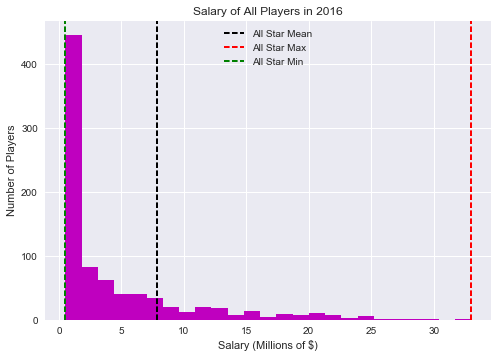

In [11]:
#Identifying All Star players in 2016
all_star_year = all_star_details[all_star_details['yearID']==2016]

#among all players, selecting the salary of only the players in the league in 2016 for the analysis
salaries_year = salary_details[salary_details['yearID']==2016]

#calculating average salary of All Star players in 2016
all_star_salaries = salaries_year.merge(all_star_year, on='playerID', how='inner')
all_star_salary_mean = all_star_salaries['salary'].mean()
all_star_salary_min = all_star_salaries['salary'].min()
all_star_salary_max = all_star_salaries['salary'].max()

def plot_histogram(data, bins, xAxis, yAxis, title, c='m'):
    '''Function to plot a histogram based on data, no. of bins input. label for x Axis - xAxis, for y Axis - yAxis,
    the title - title and the color of the graph - c (optional)'''
    plt.hist(data,bins,color=c)
    plt.xlabel(xAxis)
    plt.ylabel(yAxis)
    plt.title(title)
    
def show_all_star_lines(mean_val,min_val,max_val,label_mean,label_min,label_max):
    '''Function to plot the All Star values on the graph. Mean Stat line-mean_val, Min Stat line-min_val, Max Stat Line-max_stat
    labels for mean Stat line, max Stat line and min Stat line - label_mean, label_min and label_max.'''
    plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=2, label=label_mean)
    plt.axvline(max_val, color='r', linestyle='dashed', linewidth=2, label=label_max)
    plt.axvline(min_val, color='g', linestyle='dashed', linewidth=2, label=label_min)   
    plt.legend()

#plotting histogram of Salary for all players in 2016 and the range of salaries of All Star players relative to the league salary
plot_histogram(salaries_year['salary']/1000000,25,'Salary (Millions of $)','Number of Players','Salary of All Players in 2016')
show_all_star_lines(all_star_salary_mean/1000000, all_star_salary_min/1000000,all_star_salary_max/1000000,
                   'All Star Mean', 'All Star Min', 'All Star Max')

As we can see from the above plot, distribution of salaries in the league doesn't follow any particular pattern. But, it is seen that most of the players are paid under 5 million $ and a handful are paid more than that. It is also surprising to see that the All Star salaries range from the lowest possible to the highest paid salary in the league. A reason for this occurrence might be the emergence of a new player with All Star potential who is on a contract that doesn't pay him a large amount at the moment.

Now, we will compare the performance of All Star players with that of the rest of the players in the league. But, first if a player has played on multiple teams that year, we will combine his stats on the different teams to determine his overall stats for the year before proceeding forward with the analysis. Also, the stats for pitchers that appear in the batting statistics will be removed as it is not a reflection of their performance (it is seen that no batter has stats in the pitching table, thus doing this the other way round isn't required).

In [12]:
#identify the batters and pitchers playing in 2016 and combining their stats if they played on different teams
pitchers_2016_m = pitching_regular_season[pitching_regular_season['yearID']==2016]
batters_2016_m = batting_regular_season[batting_regular_season['yearID']==2016]

pitchers_2016 = pitchers_2016_m.groupby('playerID', as_index=False).sum()
batters_2016 = batters_2016_m.groupby('playerID', as_index=False).sum()

#removing the pitchers appearing in the batters table
batters_2016 = batters_2016[~(batters_2016['playerID'].isin(pitchers_2016['playerID']))]

#identifying the stats for the All Star pitchers and All Star batters this year
all_star_pitchers = pitchers_2016[(pitchers_2016['playerID'].isin(all_star_year['playerID']))]
all_star_batters = batters_2016[(batters_2016['playerID'].isin(all_star_year['playerID']))]

#selecting the ERA data for pitchers and the RBI data for batters from the All Star Player data for analysis
ERA_all_star = all_star_pitchers['ERA']
RBI_all_star = all_star_batters['RBI']

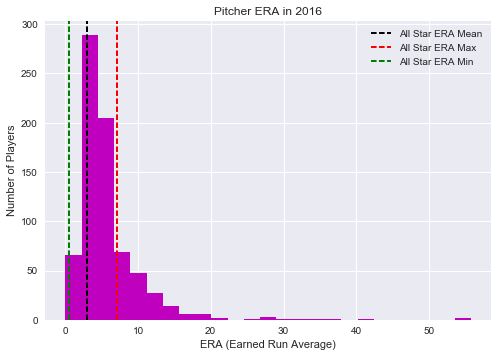

In [13]:
#plotting the ERA for the pitchers in the league in 2016
plot_histogram(pitchers_2016['ERA'],25,'ERA (Earned Run Average)','Number of Players','Pitcher ERA in 2016')
show_all_star_lines(ERA_all_star.mean(), ERA_all_star.min(),ERA_all_star.max(),
                   'All Star ERA Mean', 'All Star ERA Min', 'All Star ERA Max')

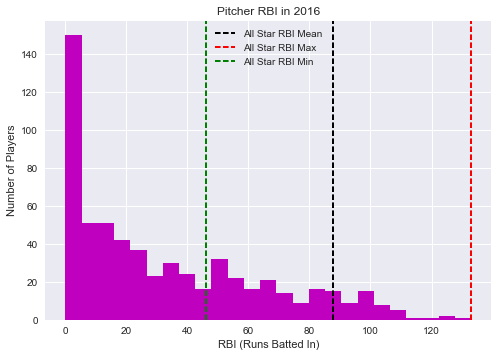

In [14]:
#plotting the RBI for the batters in the league in 2016
plot_histogram(batters_2016['RBI'],25,'RBI (Runs Batted In)','Number of Players','Pitcher RBI in 2016')
show_all_star_lines(RBI_all_star.mean(), RBI_all_star.min(),RBI_all_star.max(),
                   'All Star RBI Mean', 'All Star RBI Min', 'All Star RBI Max')

From the above two graphs we can see that the All Star players are among the top performers in the league in both the batting and the pitching categories. We can see that the minumum ERA and maximum RBI posted by them is the elite performance in the league. But, we also see that the minimum value of RBI and maximum value ERA for players selected to the All Star team is too low for RBI and too high for ERA. This may be because, the performance of certain players fell off after the All Star game. But, as we don't have data within a year available to us, it is difficult to back this statement.

From our analysis, it is clear that players selected for the All Star team perform much better than other players and are among the top performers in the league. Thus, it is plausible that being a better performer would command a higher salary and it can be said to be justified to pay All Star players a higher salary than others.

## Conclusions:

An analysis has been performed and the questions posed have been addressed. They are summarized below:

**Question 1**: In sports is often said, "A team is as good as its best player". Is this true?

Assumptions: This analysis was performed from the year 1962 onwards for players who have atleast played 20 games a season.

The analysis showed a weak dependence between RBI and winning percentage for the batters and ERA and winning percentage for the pitchers through the determination of Pearson Correlation coefficient. On comparing these coefficients with the Pearson correlation coefficients achieved between Runs scored and winning percentage for the batters and the Strike outs pitched and winning percentage for the pitchers, a definitive conclusion couldn't be reached as among the batters the coefficient for runs scored was higher than that for RBI and among pitchers, the coefficient for ERA was higher than that for strike outs pitched. As RBI and ERA are the true measure of an individuals performance in baseball, the results obtained were contradictory and thus, the statement "A team is as good as its best player" couldn't be definitively proved to be true.

To definitively this question, game by game analysis needs to be performed so as to determine the relation between the RBI, ERA posted by the player in that game and the outcome for his team.

**Question 2**: What are the performance criteria required for gaining an entry into the Hall of Fame as a player?

Assumptions: Players voted in the Hall of Fame by the BBWAA only selected for analysis.

Average Stats for players meeting the criteria defined above are calculated and compared with the average stats for players not in the Hall of Fame. After performing this comparison, a final list of players that meet this criteria is printed along with the criteria used for this identification.

**Question 3**: How much are All Star players paid compared to the rest of the field? Is this justified?

Assumptions: Analysis is performed on a per year basis. Here, analysis is being performed for the year 2016

A plot of the salaries payed to all players in the league is shown and the range, average salaries for All Star players that year are displayed. Then, individual performance is analyzed seperately for pitchers and batters by analyzing ERA and RBI posted by them through the season. It is clear from the plots that All Star players are among the top performers in the league and the salary paid to them seems to be justified. 

A follow on comparison comparing the statistics of these players before and after the All Star game needs to be performed to verify that players who were the top performers before the All Star game were the ones selected for the All Star game.